# To do 
- add choosing gpus 
- add random seed for all ( from server code) ( add it to github) 
- implement baseline transformer  
- start train with it 
- connect with git cleaned version. The smartest version of my code and thoughts . 
- make report 

# Install libraries 


In [1]:
import sys, os


import sklearn
import mne
import wandb
sys.path.insert(1, os.path.realpath(os.path.pardir))



from nilearn import image
from nilearn import plotting

import numpy as np
import matplotlib.pyplot as plt

import mne
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking
from nilearn.input_data import NiftiLabelsMasker


# animation part
from IPython.display import HTML
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation



## torch libraries 

import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


/home/user/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


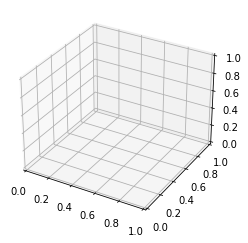

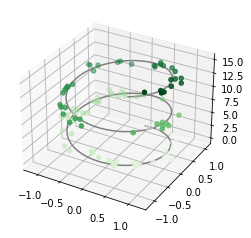

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
# from utils import  dataset_noddi
# from utils import preproc
# from utils import torch_dataset
# from utils import train_utils
# from utils import inference
# from utils.models_arch import autoencoder_v3

# Set all hyperparameters
Parameters of dataset, random seed and so on 


# Upload dataset 
Upload EEG fMRI and labels 

In [5]:




df_eeg, df_fmri, labels_roi = dataset_noddi.download_bids_noddi_dataset(patient, path_to_dataset, 
                                                                    remove_confounds=remove_confounds,
                                                                    verbose=True)
df_eeg_align, df_fmri_interp, fps = dataset_noddi.interpolate_df_eeg_fmri(df_eeg, df_fmri)

ALL path:  ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_desc-confounds_timeseries.tsv ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json ../data/NODDI_dataset_light/derivatives/sub-32/eeg/sub-32_task-rest_eeg.vhdr


/home/user/common/koval_alvi/fmri_eeg_project/utils/dataset_noddi.py:131: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)
/home/user/common/koval_alvi/fmri_eeg_project/utils/dataset_noddi.py:131: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)


fMRI info: {'RepetitionTime': 2.16, 'SkullStripped': False, 'SliceTimingCorrected': True, 'StartTime': 1.049, 'TaskName': 'rest'}
Dimension of our EEG data:  (162023, 64)
Dimension of our fMRi data:  (97, 115, 97, 300)
Dimension of our fMRi Roi data:  (300, 21)
RoI:  ['Left Cerebral White Matter', 'Left Cerebral Cortex ', 'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex ', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']


# Process data
- divide on train and test 
- Process data separately
- apply bold delay correction

In [6]:
config = dict(  
                dataset_name = 'NODDI',
                fps = fps,
                n_channels = 64,
                n_roi = 21,
                test_sec = 60, # in seconds.
                freqs = np.linspace(2, 100, 16), 
                
                bold_delay = 5,
                to_many = True,
                random_subsample = True,
                sample_per_epoch = 25600, 
                WINDOW_SIZE = 1024,
                    
                optimizer='adam',
                lr=0.001,
                weight_decay=0.00001, 
                batch_size=512, 

                loss_function = 'mse', 
                model_type = '1D_CNN_AE_changed'
                )


hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],
                      n_res_block=0, 
                      channels=[32, 32, 64, 64], 
                      kernel_sizes=[15, 11, 5, 5],
                      strides=[8, 8, 4]
                     )


config = {**hp_autoencoder, **config}

params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': config['batch_size'],
              'shuffle': False}

In [7]:
config['bold_delay']

5

In [8]:




train_dataset_prep, freqs, inp_stats_train, out_stats_train = preproc.preproc_dataset((df_eeg_align.to_numpy().T, df_fmri_interp.to_numpy().T), 
                                                                                              fps=config['fps'], 
                                                                                              freqs=config['freqs'], 
                                                                                              inp_means_stds=None, 
                                                                                              out_means_stds=None)
# test_dataset_prep, freqs, inp_stats_test, out_stats_test = preproc.preproc_dataset(test_dataset,
#                                                                                             fps = config['fps'],
#                                                                                             freqs=config['freqs'],                                                                    
#                                                                                             inp_means_stds=inp_stats_train, 
#                                                                                             out_means_stds=out_stats_train)

train_dataset_prep, test_dataset_prep = preproc.divide_train_test(train_dataset_prep[0].T, 
                                                                    train_dataset_prep[1].T, 
                                                                    fps=config['fps'], 
                                                                    test_sec= config['test_sec'])
# apply time dealy corrected
train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, config['fps'], config['bold_delay'])
test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, config['fps'], config['bold_delay'])


# torch dataset creation 
torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                            random_sample=config['random_subsample'], 
                                                            sample_per_epoch=config['sample_per_epoch'])

torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                            random_sample=False, 
                                                            sample_per_epoch=None)

# init dataloaders for training
train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
val_loader = torch.utils.data.DataLoader(torch_dataset_test, **params_val)


Size of eeg features (64, 16, 161460) | fmri (21, 161460)
Size of train dataset: eeg (64, 16, 146460) | fmri (21, 146460)
Size of test dataset: eeg (64, 16, 15000) | fmri (21, 15000)


In [9]:
model = autoencoder_v3.AutoEncoder1D(**hp_autoencoder)

loss_func = train_utils.make_mse_loss()
train_step = train_utils.train_step

optimizer = optim.Adam(model.parameters(), 
                       lr=config['lr'], 
                       weight_decay=config['weight_decay'])


print(summary(model, torch.zeros(4, 64, 16, 1024), show_input=False))


-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [4, 16, 16, 1024]           1,040           1,040
          Conv1d-2         [4, 32, 1024]           8,224           8,224
         Block1D-3          [4, 32, 128]           5,536           5,536
         Block1D-4           [4, 64, 16]          19,264          19,264
         Block1D-5            [4, 64, 4]          21,312          21,312
         Block1D-6            [4, 64, 4]          21,312          21,312
          Conv1d-7            [4, 21, 4]           1,365           1,365
        Upsample-8         [4, 21, 1024]               0               0
Total params: 78,053
Trainable params: 78,053
Non-trainable params: 0
-------------------------------------------------------------------------


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


# Model training

In [ ]:
n_runs = 5

for i in range(n_runs):
    
    model = autoencoder_v3.AutoEncoder1D(**hp_autoencoder)

    loss_func = train_utils.make_mse_loss()
    train_step = train_utils.train_step

    optimizer = optim.Adam(model.parameters(), 
                       lr=config['lr'], 
                       weight_decay=config['weight_decay'])
    
    
    parameters = {
        'EPOCHS': 25,
        'model': model, 
        'train_loader': train_loader, 
        'val_loader': val_loader, 
        'loss_function': loss_func,
        'train_step': train_step,
        'optimizer': optimizer, 
        'device': 'cuda', 
        'raw_test_data': test_dataset_prep,
        'show_info': 1, 
        'num_losses': 5,
        'labels': labels_roi,
        'inference_function': inference.model_inference_function, 
        'to_many': config['to_many']
    }



    path_to_save_wandb = 'common/koval_alvi/Checkpoints/wandb_brain'
    
    
    with wandb.init(project="eeg_fmri", config=config, save_code=True):
        
        if i == 0: 
            exp_name = wandb.run.name
        
        wandb.run.name = exp_name +'_run_' + str(i)
        
        print(config)
        print(parameters['model'])
        print(summary(model, torch.zeros(4, 64, 16, config['WINDOW_SIZE']), show_input=False))
        
        model = train_utils.wanb_train_regression(**parameters)
        

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: koval_alvi (use `wandb login --relogin` to force relogin)


{'n_electrodes': 64, 'n_freqs': 16, 'n_channels_out': 21, 'n_res_block': 0, 'channels': [32, 32, 64, 64], 'kernel_sizes': [15, 11, 5, 5], 'strides': [8, 8, 4], 'dataset_name': 'NODDI', 'fps': 250, 'n_channels': 64, 'n_roi': 21, 'test_sec': 60, 'freqs': array([  2.        ,   8.53333333,  15.06666667,  21.6       ,
        28.13333333,  34.66666667,  41.2       ,  47.73333333,
        54.26666667,  60.8       ,  67.33333333,  73.86666667,
        80.4       ,  86.93333333,  93.46666667, 100.        ]), 'bold_delay': 5, 'to_many': True, 'random_subsample': True, 'sample_per_epoch': 25600, 'WINDOW_SIZE': 1024, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 512, 'loss_function': 'mse', 'model_type': '1D_CNN_AE_changed'}
AutoEncoder1D(
  (spatial_reduce_2d): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (spatial_reduce): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
  (downsample_blocks): ModuleList(
    (0): Block1D(
      (downsample): AvgPool1d(kernel_size=

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 2 train loss_0 : 0.875 val loss_0 : 1.1 train loss_1 : 0.289 val loss_1 : -0.000149 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 3 train loss_0 : 0.811 val loss_0 : 1.13 train loss_1 : 0.38 val loss_1 : -0.00773 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 4 train loss_0 : 0.766 val loss_0 : 1.17 train loss_1 : 0.432 val loss_1 : -0.0213 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 5 train loss_0 : 0.74 val loss_0 : 1.2 train loss_1 : 0.464 val loss_1 : -0.0323 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 6 train loss_0 : 0.716 val loss_0 : 1.24 train loss_1 : 0.488 val loss_1 : -0.0418 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 7 train loss_0 : 0.703 val loss_0 : 1.24 train loss_1 : 0.504 val loss_1 : -0.043 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 8 train loss_0 : 0.691 val loss_0 : 1.25 train loss_1 : 0.518 val loss_1 : -0.0421 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 9 train loss_0 : 0.681 val loss_0 : 1.26 train loss_1 : 0.53 val loss_1 : -0.0422 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 10 train loss_0 : 0.674 val loss_0 : 1.27 train loss_1 : 0.539 val loss_1 : -0.0433 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................

/home/user/common/koval_alvi/fmri_eeg_project/utils/inference.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(7, 3, figsize = (10, 15), sharex=True, sharey=True)



Epoch 11 train loss_0 : 0.666 val loss_0 : 1.26 train loss_1 : 0.547 val loss_1 : -0.0386 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 12 train loss_0 : 0.66 val loss_0 : 1.27 train loss_1 : 0.555 val loss_1 : -0.0361 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 13 train loss_0 : 0.654 val loss_0 : 1.28 train loss_1 : 0.561 val loss_1 : -0.0406 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 14 train loss_0 : 0.654 val loss_0 : 1.28 train loss_1 : 0.565 val loss_1 : -0.0426 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 15 train loss_0 : 0.647 val loss_0 : 1.28 train loss_1 : 0.569 val loss_1 : -0.039 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 16 train loss_0 : 0.642 val loss_0 : 1.28 train loss_1 : 0.574 val loss_1 : -0.0362 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 17 train loss_0 : 0.639 val loss_0 : 1.29 train loss_1 : 0.576 val loss_1 : -0.0324 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 18 train loss_0 : 0.639 val loss_0 : 1.29 train loss_1 : 0.58 val loss_1 : -0.0354 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 19 train loss_0 : 0.636 val loss_0 : 1.29 train loss_1 : 0.583 val loss_1 : -0.0352 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 20 train loss_0 : 0.633 val loss_0 : 1.29 train loss_1 : 0.585 val loss_1 : -0.0312 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 21 train loss_0 : 0.632 val loss_0 : 1.3 train loss_1 : 0.588 val loss_1 : -0.0309 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 22 train loss_0 : 0.633 val loss_0 : 1.29 train loss_1 : 0.589 val loss_1 : -0.0287 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 23 train loss_0 : 0.627 val loss_0 : 1.29 train loss_1 : 0.591 val loss_1 : -0.0253 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 24 train loss_0 : 0.628 val loss_0 : 1.29 train loss_1 : 0.593 val loss_1 : -0.0205 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 25 train loss_0 : 0.625 val loss_0 : 1.29 train loss_1 : 0.595 val loss_1 : -0.0266 


train/loss_0,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/loss_1,▁▃▅▆▆▆▇▇▇▇▇▇▇████████████
val/corr_mean,▁▁▁▂▂▃▄▅▆▆▇▇▇▇███████▇▇▇▇
val/loss_0,▁▂▃▄▅▆▆▇▇▇▇▇▇█▇██████████
val/loss_1,▅█▇▅▃▁▁▁▁▁▂▂▁▁▂▂▃▂▂▃▃▃▄▅▄
train/loss_0,0.62532
train/loss_1,0.59516
val/corr_mean,0.12388
val/loss_0,1.29199
val/loss_1,-0.0266


{'n_electrodes': 64, 'n_freqs': 16, 'n_channels_out': 21, 'n_res_block': 0, 'channels': [32, 32, 64, 64], 'kernel_sizes': [15, 11, 5, 5], 'strides': [8, 8, 4], 'dataset_name': 'NODDI', 'fps': 250, 'n_channels': 64, 'n_roi': 21, 'test_sec': 60, 'freqs': array([  2.        ,   8.53333333,  15.06666667,  21.6       ,
        28.13333333,  34.66666667,  41.2       ,  47.73333333,
        54.26666667,  60.8       ,  67.33333333,  73.86666667,
        80.4       ,  86.93333333,  93.46666667, 100.        ]), 'bold_delay': 5, 'to_many': True, 'random_subsample': True, 'sample_per_epoch': 25600, 'WINDOW_SIZE': 1024, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 512, 'loss_function': 'mse', 'model_type': '1D_CNN_AE_changed'}
AutoEncoder1D(
  (spatial_reduce_2d): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (spatial_reduce): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
  (downsample_blocks): ModuleList(
    (0): Block1D(
      (downsample): AvgPool1d(kernel_size=

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


..................................................
Epoch 1 train loss_0 : 0.987 val loss_0 : 1.05 train loss_1 : 0.124 val loss_1 : -0.00241 train loss_2 : 0.0 val loss_2 : 0.0 train loss_3 : 0.0 val loss_3 : 0.0 train loss_4 : 0.0 val loss_4 : 0.0 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 2 train loss_0 : 0.875 val loss_0 : 1.09 train loss_1 : 0.286 val loss_1 : -0.00619 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 3 train loss_0 : 0.804 val loss_0 : 1.13 train loss_1 : 0.381 val loss_1 : -0.0107 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 4 train loss_0 : 0.762 val loss_0 : 1.16 train loss_1 : 0.434 val loss_1 : -0.0113 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 5 train loss_0 : 0.731 val loss_0 : 1.19 train loss_1 : 0.469 val loss_1 : -0.025 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 6 train loss_0 : 0.714 val loss_0 : 1.2 train loss_1 : 0.492 val loss_1 : -0.0202 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 7 train loss_0 : 0.695 val loss_0 : 1.21 train loss_1 : 0.513 val loss_1 : -0.0182 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 8 train loss_0 : 0.684 val loss_0 : 1.21 train loss_1 : 0.526 val loss_1 : -0.0172 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 9 train loss_0 : 0.676 val loss_0 : 1.22 train loss_1 : 0.536 val loss_1 : -0.0231 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 10 train loss_0 : 0.667 val loss_0 : 1.23 train loss_1 : 0.547 val loss_1 : -0.0236 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 11 train loss_0 : 0.661 val loss_0 : 1.23 train loss_1 : 0.554 val loss_1 : -0.0225 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 12 train loss_0 : 0.654 val loss_0 : 1.24 train loss_1 : 0.561 val loss_1 : -0.0206 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 13 train loss_0 : 0.651 val loss_0 : 1.24 train loss_1 : 0.565 val loss_1 : -0.0189 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 14 train loss_0 : 0.646 val loss_0 : 1.24 train loss_1 : 0.57 val loss_1 : -0.0189 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 15 train loss_0 : 0.643 val loss_0 : 1.25 train loss_1 : 0.574 val loss_1 : -0.0212 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 16 train loss_0 : 0.641 val loss_0 : 1.25 train loss_1 : 0.578 val loss_1 : -0.0234 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 17 train loss_0 : 0.639 val loss_0 : 1.26 train loss_1 : 0.58 val loss_1 : -0.0269 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 18 train loss_0 : 0.634 val loss_0 : 1.27 train loss_1 : 0.585 val loss_1 : -0.0294 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 19 train loss_0 : 0.632 val loss_0 : 1.26 train loss_1 : 0.586 val loss_1 : -0.027 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 20 train loss_0 : 0.631 val loss_0 : 1.29 train loss_1 : 0.589 val loss_1 : -0.0357 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 21 train loss_0 : 0.628 val loss_0 : 1.28 train loss_1 : 0.591 val loss_1 : -0.0325 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 22 train loss_0 : 0.63 val loss_0 : 1.28 train loss_1 : 0.592 val loss_1 : -0.0333 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 23 train loss_0 : 0.631 val loss_0 : 1.29 train loss_1 : 0.595 val loss_1 : -0.0391 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 24 train loss_0 : 0.624 val loss_0 : 1.29 train loss_1 : 0.597 val loss_1 : -0.0383 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 25 train loss_0 : 0.624 val loss_0 : 1.29 train loss_1 : 0.598 val loss_1 : -0.0348 


train/loss_0,█▆▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_1,▁▃▅▆▆▆▇▇▇▇▇▇█████████████
val/corr_mean,█▆▆▅▃▁▁▂▃▃▆▅▆▇▇▆▅▅▄▄▄▂▃▃▃
val/loss_0,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
val/loss_1,█▇▆▆▄▅▅▅▄▄▄▅▅▅▄▄▃▃▃▂▂▂▁▁▂
train/loss_0,0.62354
train/loss_1,0.59823
val/corr_mean,-0.05059
val/loss_0,1.28705
val/loss_1,-0.03479


{'n_electrodes': 64, 'n_freqs': 16, 'n_channels_out': 21, 'n_res_block': 0, 'channels': [32, 32, 64, 64], 'kernel_sizes': [15, 11, 5, 5], 'strides': [8, 8, 4], 'dataset_name': 'NODDI', 'fps': 250, 'n_channels': 64, 'n_roi': 21, 'test_sec': 60, 'freqs': array([  2.        ,   8.53333333,  15.06666667,  21.6       ,
        28.13333333,  34.66666667,  41.2       ,  47.73333333,
        54.26666667,  60.8       ,  67.33333333,  73.86666667,
        80.4       ,  86.93333333,  93.46666667, 100.        ]), 'bold_delay': 5, 'to_many': True, 'random_subsample': True, 'sample_per_epoch': 25600, 'WINDOW_SIZE': 1024, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 512, 'loss_function': 'mse', 'model_type': '1D_CNN_AE_changed'}
AutoEncoder1D(
  (spatial_reduce_2d): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (spatial_reduce): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
  (downsample_blocks): ModuleList(
    (0): Block1D(
      (downsample): AvgPool1d(kernel_size=

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


..................................................
Epoch 1 train loss_0 : 0.983 val loss_0 : 1.04 train loss_1 : 0.118 val loss_1 : 0.00989 train loss_2 : 0.0 val loss_2 : 0.0 train loss_3 : 0.0 val loss_3 : 0.0 train loss_4 : 0.0 val loss_4 : 0.0 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 2 train loss_0 : 0.876 val loss_0 : 1.08 train loss_1 : 0.284 val loss_1 : 0.0132 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 3 train loss_0 : 0.807 val loss_0 : 1.12 train loss_1 : 0.38 val loss_1 : -0.00401 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 4 train loss_0 : 0.763 val loss_0 : 1.15 train loss_1 : 0.433 val loss_1 : -0.0241 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 5 train loss_0 : 0.736 val loss_0 : 1.18 train loss_1 : 0.467 val loss_1 : -0.0314 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 6 train loss_0 : 0.715 val loss_0 : 1.19 train loss_1 : 0.489 val loss_1 : -0.0294 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 7 train loss_0 : 0.702 val loss_0 : 1.2 train loss_1 : 0.505 val loss_1 : -0.0235 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 8 train loss_0 : 0.692 val loss_0 : 1.2 train loss_1 : 0.52 val loss_1 : -0.0203 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 9 train loss_0 : 0.677 val loss_0 : 1.22 train loss_1 : 0.532 val loss_1 : -0.0215 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 10 train loss_0 : 0.67 val loss_0 : 1.23 train loss_1 : 0.541 val loss_1 : -0.0198 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 11 train loss_0 : 0.665 val loss_0 : 1.23 train loss_1 : 0.548 val loss_1 : -0.0232 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 12 train loss_0 : 0.659 val loss_0 : 1.24 train loss_1 : 0.554 val loss_1 : -0.0292 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 13 train loss_0 : 0.656 val loss_0 : 1.25 train loss_1 : 0.559 val loss_1 : -0.0265 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 14 train loss_0 : 0.65 val loss_0 : 1.25 train loss_1 : 0.564 val loss_1 : -0.0312 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 15 train loss_0 : 0.648 val loss_0 : 1.25 train loss_1 : 0.569 val loss_1 : -0.0249 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 16 train loss_0 : 0.645 val loss_0 : 1.25 train loss_1 : 0.572 val loss_1 : -0.0223 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 17 train loss_0 : 0.642 val loss_0 : 1.25 train loss_1 : 0.575 val loss_1 : -0.0244 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 18 train loss_0 : 0.639 val loss_0 : 1.26 train loss_1 : 0.578 val loss_1 : -0.0291 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 19 train loss_0 : 0.637 val loss_0 : 1.25 train loss_1 : 0.581 val loss_1 : -0.0233 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 20 train loss_0 : 0.633 val loss_0 : 1.26 train loss_1 : 0.585 val loss_1 : -0.0258 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 21 train loss_0 : 0.632 val loss_0 : 1.25 train loss_1 : 0.586 val loss_1 : -0.0216 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 22 train loss_0 : 0.631 val loss_0 : 1.26 train loss_1 : 0.588 val loss_1 : -0.02 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 23 train loss_0 : 0.63 val loss_0 : 1.26 train loss_1 : 0.59 val loss_1 : -0.017 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 24 train loss_0 : 0.632 val loss_0 : 1.27 train loss_1 : 0.591 val loss_1 : -0.0224 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 25 train loss_0 : 0.624 val loss_0 : 1.27 train loss_1 : 0.594 val loss_1 : -0.0229 


train/loss_0,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_1,▁▃▅▆▆▆▇▇▇▇▇▇▇████████████
val/corr_mean,▁▁▄▅▆▆█▇▆▆▅▅▅▅▅▅▆▅▅▅▅▆▆▅▆
val/loss_0,▁▂▃▅▅▆▆▆▆▇▇▇▇█▇▇▇████████
val/loss_1,▇█▅▂▁▁▂▃▃▃▂▁▂▁▂▂▂▁▂▂▃▃▃▂▂
train/loss_0,0.62441
train/loss_1,0.59402
val/corr_mean,0.02659
val/loss_0,1.26541
val/loss_1,-0.02286


{'n_electrodes': 64, 'n_freqs': 16, 'n_channels_out': 21, 'n_res_block': 0, 'channels': [32, 32, 64, 64], 'kernel_sizes': [15, 11, 5, 5], 'strides': [8, 8, 4], 'dataset_name': 'NODDI', 'fps': 250, 'n_channels': 64, 'n_roi': 21, 'test_sec': 60, 'freqs': array([  2.        ,   8.53333333,  15.06666667,  21.6       ,
        28.13333333,  34.66666667,  41.2       ,  47.73333333,
        54.26666667,  60.8       ,  67.33333333,  73.86666667,
        80.4       ,  86.93333333,  93.46666667, 100.        ]), 'bold_delay': 5, 'to_many': True, 'random_subsample': True, 'sample_per_epoch': 25600, 'WINDOW_SIZE': 1024, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 512, 'loss_function': 'mse', 'model_type': '1D_CNN_AE_changed'}
AutoEncoder1D(
  (spatial_reduce_2d): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (spatial_reduce): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
  (downsample_blocks): ModuleList(
    (0): Block1D(
      (downsample): AvgPool1d(kernel_size=

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


..................................................
Epoch 1 train loss_0 : 0.986 val loss_0 : 1.04 train loss_1 : 0.112 val loss_1 : 0.0117 train loss_2 : 0.0 val loss_2 : 0.0 train loss_3 : 0.0 val loss_3 : 0.0 train loss_4 : 0.0 val loss_4 : 0.0 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 2 train loss_0 : 0.879 val loss_0 : 1.07 train loss_1 : 0.278 val loss_1 : 0.0101 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 3 train loss_0 : 0.812 val loss_0 : 1.1 train loss_1 : 0.373 val loss_1 : 0.0246 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 4 train loss_0 : 0.765 val loss_0 : 1.12 train loss_1 : 0.43 val loss_1 : 0.0291 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 5 train loss_0 : 0.738 val loss_0 : 1.14 train loss_1 : 0.465 val loss_1 : 0.0307 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 6 train loss_0 : 0.714 val loss_0 : 1.15 train loss_1 : 0.49 val loss_1 : 0.0313 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 7 train loss_0 : 0.702 val loss_0 : 1.15 train loss_1 : 0.506 val loss_1 : 0.0381 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 8 train loss_0 : 0.688 val loss_0 : 1.16 train loss_1 : 0.521 val loss_1 : 0.0421 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 9 train loss_0 : 0.68 val loss_0 : 1.16 train loss_1 : 0.532 val loss_1 : 0.0474 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 10 train loss_0 : 0.67 val loss_0 : 1.17 train loss_1 : 0.542 val loss_1 : 0.0416 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


...............................

# 